## Needed Libraries
 - **Pandas** is used to load files and to analyze certain data
 - **Numpy** is used to perform some mathematical calculations and to use arrays
 - **Matplotlib** is used to plot the data

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import json
from scipy.interpolate import interp1d, interp2d

### Histograms for monthly values
First we'll use monthly values to plot a histogram of all the data and seasonal ones, we'll load the values located in the file *itcwv_monthly.txt*

The ***loadlist()*** function is used to load a text file as a list

In [1]:
def loadlist(array, name='file'):
    with open(name, "r") as f:
        for line in f:
            array.append(float(line.strip()))

### ERA 5 Monthly Data 

In [3]:
tcwv_m = []
loadlist(tcwv_m, 'TCWV/ElAlto/itcwv_monthly.txt')

The ***plothist()*** function is used to plot a histogram from a list, the parameters are:
 - The list
 - The density ***p*** for percentages and ***f*** for frequencies
 - The title of the plot (Optional)
 - The X label of the plot (Optional)
 - The Y label of the plot (Optional)
 - The minimum and maximum values of X axis (Optional)
 - The minimum and maximum values of Y axis (Optional)
 - The number of bins desired (default is 10)

In [6]:
def plothist(array, den='p', title=0, xl=0, yl=0, xmin=0, xmax=0, ymin=0, ymax=0, bz=1):
    den = True if den == 'p' else None
    barray = np.arange(xmin, xmax + bz, bz)
    hist, bin_edges = np.histogram(array, bins = barray, density=den)
    r_bin_edges = np.round(bin_edges,0)
    hist = hist*100 if den else hist
    plt.bar(r_bin_edges[:-1], hist, width = 0.8, color='#0504aa',alpha=0.8)
    plt.ylim(ymin, ymax) if ymax != 0 else None
    plt.xlim(xmin - 1, xmax) if xmax != 0 else None
    plt.grid(axis='y', alpha=0.75)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title(title,fontsize=15) if title != 0 else None
    plt.xlabel(xl, fontsize=15) if xl != 0 else None
    plt.ylabel(yl, fontsize=15) if yl != 0 else None
    plt.show()
    return hist, bin_edges, r_bin_edges

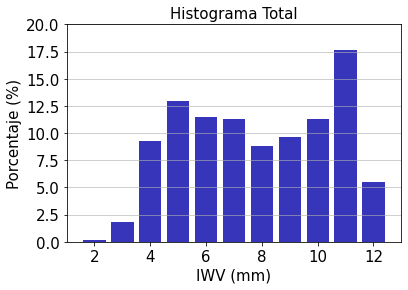

In [14]:
th, te, tre = plothist(tcwv_m, den = 'p', title = 'Histograma Total', xl = 'IWV (mm)', yl = 'Porcentaje (%)', xmin = 2, xmax = 13, ymin = 0, ymax = 20)

### Seasonal Histograms
To plot seasonal histograms we'll create a list for each season and we'll use the function ***ex_season()*** to extract values from one month to another

In [8]:
def ex_season(array, start, end):
    pos = 0
    c = 0
    y = int((len(array)/12))
    aux = [0] * (end - start + 1) * y
    for i in range(0,y):
        for j in range(start,end + 1):
            aux[c] = array[pos + j]
            c += 1
        pos += 12
    return aux

In [9]:
summertcwv = ex_season(tcwv_m, 0, 2)
autumntcwv = ex_season(tcwv_m, 3, 5)
wintertcwv = ex_season(tcwv_m, 6, 8)
springtcwv = ex_season(tcwv_m, 9, 11)

### Summer Histogram

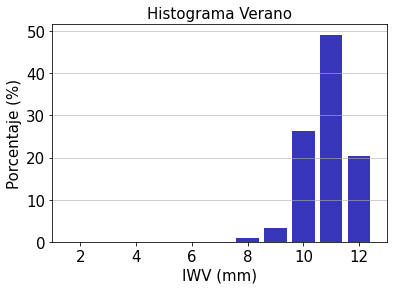

In [16]:
su_h, su_e, su_re = plothist(summertcwv, den = 'p', title = 'Histograma Verano', xl = 'IWV (mm)', yl = 'Porcentaje (%)', xmin = 2 , xmax = 13)

### Autumn Histogram

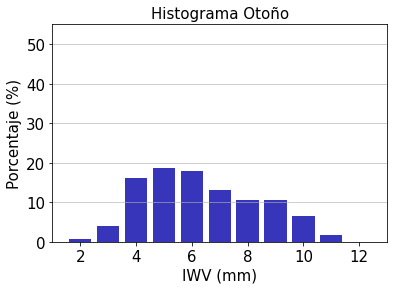

In [18]:
au_h, au_e, au_re = plothist(autumntcwv, den = 'p', title = 'Histograma Otoño', xl = 'IWV (mm)', yl = 'Porcentaje (%)', xmin = 2 , xmax = 13, ymin = 0, ymax = 55)

### Winter Histogram

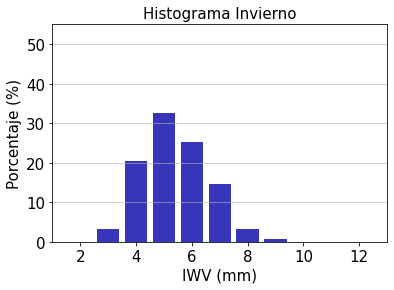

In [19]:
wi_h, wi_e, wi_re = plothist(wintertcwv, den = 'p', title = 'Histograma Invierno', xl = 'IWV (mm)', yl = 'Porcentaje (%)', xmin = 2 , xmax = 13, ymin = 0, ymax = 55)

### Spring Histogram

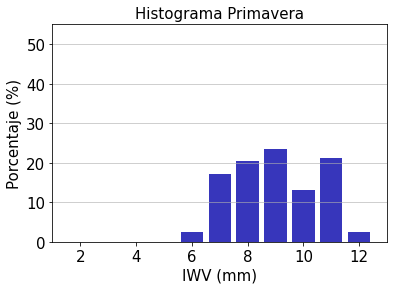

In [21]:
sp_h, sp_e, sp_re = plothist(springtcwv, den = 'p', title = 'Histograma Primavera', xl = 'IWV (mm)', yl = 'Porcentaje (%)', xmin = 2 , xmax = 13, ymin = 0, ymax = 55)

### CCDF Plot

In [84]:
def plotcdf(array, plot=1, bins=50):
    ccdf, X, _ = plt.hist(array, bins = bins, density=True, log=True, cumulative=-1, histtype='step')
    ccdf = np.append(ccdf * 100, 0)
    plt.clf()
    plt.grid(True, which="both")
    plt.semilogy(X, ccdf, label='CCDF')
    plt.legend(loc='best')
    plt.xlabel('IWV (mm)')
    plt.ylabel('Probabilidad (%)')
    plt.title('CCDF')
    plt.show() if plot == 1 else plt.clf()
    return X, ccdf

### Linear Interpolation

In [30]:
def interp_list(x, y, new_x):
    new_y = []
    y_interp = interp1d(x, y, kind='linear')
    new_y = np.array([float(y_interp(val)) for val in new_x])
    return new_y

In [7]:
prob_nom = [0.1, 0.2, 0.3, 0.5, 1, 2, 3, 5, 10, 20, 30, 50, 60, 70, 80, 90, 95, 99]

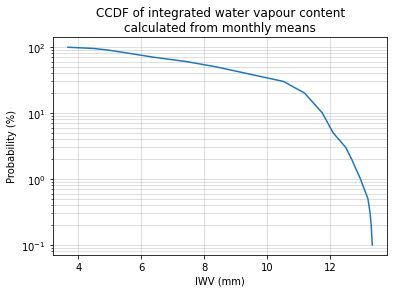

In [38]:
X, ccdf = plotcdf(tcwv_m, 0)
Xn = interp_list(ccdf, X, prob_nom)
plt.semilogy(Xn, prob_nom)
plt.grid(True, which="both", alpha=0.5)
plt.title('CCDF of integrated water vapour content\ncalculated from monthly means')
plt.xlabel('IWV (mm)')
plt.ylabel('Probability (%)')
plt.show()

### Water Vapor Attenuation

In [39]:
wat_file = pd.read_csv('ITUFiles/wat676.csv')
oxy_file = pd.read_csv('ITUFiles/oxy676.csv')
fw = wat_file['fw'].to_numpy()
b1 = wat_file['b1'].to_numpy()
b2 = wat_file['b2'].to_numpy()
b3 = wat_file['b3'].to_numpy()
b4 = wat_file['b4'].to_numpy()
b5 = wat_file['b5'].to_numpy()
b6 = wat_file['b6'].to_numpy()
fo = oxy_file['fo'].to_numpy()
a1 = oxy_file['a1'].to_numpy()
a2 = oxy_file['a2'].to_numpy()
a3 = oxy_file['a3'].to_numpy()
a4 = oxy_file['a4'].to_numpy()
a5 = oxy_file['a5'].to_numpy()
a6 = oxy_file['a6'].to_numpy()

In [40]:
def itu676(f, p, rho, T):
    # p: dry air presure (hPa)
    # e: water vaour partial pressure (hPa)
    # theta (Θ): 300/T
    # T: Temperature
    theta = 300/T
    e = (rho*T)/216.7
    So = a1 * (1e-7) * p * (theta**3) * np.exp(a2 * (1 - theta))
    Sw = b1 * (1e-1) * e * (theta**3.5) * np.exp(b2 * (1 - theta))
    deltao = (a5 + a6 * theta) * (1e-4) * (p + e) * (theta**0.8)
    deltaw = 0
    deltafo_wd = a3 * (1e-4) * (p * (theta**(0.8 - a4)) + 1.1 * e * theta)
    deltafw_wd = b3 * (1e-4) * (p * (theta**b4) + b5 * e * (theta**b6))
    deltafo = np.sqrt(deltafo_wd**2 + 2.25e-6)
    deltafw = 0.535 * deltafw_wd + np.sqrt((0.217 * deltafw_wd**2) + (2.1316e-12 * (fw**2))/(theta))
    Fo = ((f)/(fo)) * (((deltafo - deltao * (fo - f))/(deltafo**2 + (fo - f)**2))+((deltafo - deltao * (fo + f))/(deltafo**2 + (fo + f)**2)))
    Fw = ((f)/(fw)) * (((deltafw - deltaw * (fw - f))/(deltafw**2 + (fw - f)**2))+((deltafw - deltaw * (fw + f))/(deltafw**2 + (fw + f)**2)))
    d = (5.6e-4) * (p + e) * (theta**0.8)
    N2Df = f * p * theta**2 * (((6.14e-5)/(d * (1+(f/d)**2)))+((1.4e-12 * p * theta**1.5)/(1 + 1.9e-5 * f**1.5)))
    N2f = sum(Fo * So) + sum(Fw * Sw) + N2Df
    y = 0.182 * f * N2f
    ywv = 0.182 * f * sum(Fw * Sw)
    yox = 0.182 * f * (sum(Fo * So) + N2Df)
    return y, ywv, yox

In [2]:
def get_elevation(lat, lon):
    key = 'Ai9NLeGblweg0P_Br_bKnbLVkkRgbG6RlH4k5FrbBctSqD32KHMuFQmRyX-apadI'
    url = 'https://dev.virtualearth.net/REST/v1/Elevation/List?key=' + key + '&points=' + str(lat) + ',' + str(lon)
    response = urllib.request.urlopen(url)
    data = json.loads(response.read().decode())
    elevation = data['resourceSets'][0]['resources'][0]['elevations'][0]
    return elevation, elevation / 1000

In [42]:
def calc_at(daily_tcwv, freq, lat, lon):
    freq = [freq] if type(freq)!=list else freq
    daily_at = [np.empty(0)] * len(freq)
    f_ref = 20.6
    p_ref = 845
    hs = get_elevation(lat,lon)[1]
    c = 0
    for f in freq:
        a = 0.2048 * np.exp(-((f-22.43)/(3.097))**2) + 0.2326 * np.exp(-((f-183.5)/(4.096))**2) + 0.2073 * np.exp(-((f-325)/(3.651))**2) - 0.1113
        b = 8.741e4 * np.exp(-0.587 * f) + 312.2 * f ** -2.38 + 0.723
        if hs < 0:
            h = 0
        elif hs >= 0 and hs < 4:
            h = hs
        else:
            h = 4
        # print(a)
        # print(b)
        for iwv in daily_tcwv:
            rho_vref = iwv / 2.38
            t_ref = 14 * np.log(0.22*iwv/2.38) + 3 + 273.15
            if f <= 20:
                a_w = (0.0176 * iwv * itu676(f, p_ref, rho_vref, t_ref)[1])/(itu676(f_ref, p_ref, rho_vref, t_ref)[1])
            else:
                a_w = (a * (h ** b) + 1)*(0.0176 * iwv * itu676(f, p_ref, rho_vref, t_ref)[1])/(itu676(f_ref, p_ref, rho_vref, t_ref)[1])
            daily_at[c] = np.append(daily_at[c], a_w)
        c += 1
    return daily_at

### ERA5 Daily Data

### El Alto

Data loading from a text file

In [110]:
tcwv_d = []
loadlist(tcwv_d, 'TCWV/ElAlto/itcwv_12.txt')

CCDF of Integrated Water Vapor

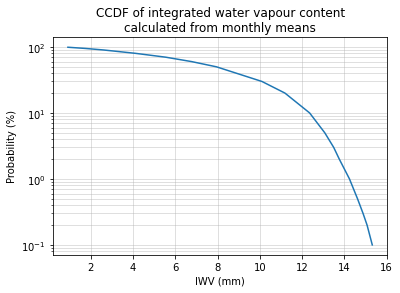

In [111]:
X, ccdf = plotcdf(tcwv_d, 0)
Xn = interp_list(ccdf, X, prob_nom)
plt.semilogy(Xn, prob_nom)
plt.grid(True, which="both", alpha=0.5)
plt.title('CCDF of integrated water vapour content\ncalculated from monthly means')
plt.xlabel('IWV (mm)')
plt.ylabel('Probability (%)')
plt.show()

Integrated Water Vapor Attenuation

In [112]:
at_20, at_40, at_50, at_75 = calc_at(tcwv_d, [20, 40, 50, 75], -16.51, -68.17)

CCDF of the IWV Attenuation

In [113]:
X_20, ccdf_20 = plotcdf(at_20, 0)
X_40, ccdf_40 = plotcdf(at_40, 0)
X_50, ccdf_50 = plotcdf(at_50, 0)
X_75, ccdf_75 = plotcdf(at_75, 0)
X_20n = interp_list(ccdf_20, X_20, prob_nom)
X_40n = interp_list(ccdf_40, X_40, prob_nom)
X_50n = interp_list(ccdf_50, X_50, prob_nom)
X_75n = interp_list(ccdf_75, X_75, prob_nom)

<Figure size 432x288 with 0 Axes>

Plot of the attenuation

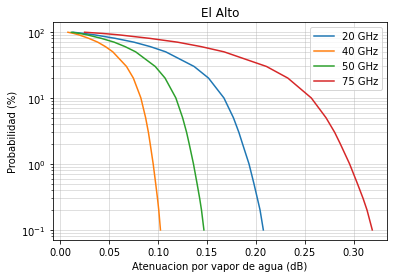

In [114]:
plt.grid(True, which="both", alpha=0.5)
plt.semilogy(X_20n, prob_nom, label='20 GHz')
plt.semilogy(X_40n, prob_nom, label='40 GHz')
plt.semilogy(X_50n, prob_nom, label='50 GHz')
plt.semilogy(X_75n, prob_nom, label='75 GHz')
plt.legend(loc='best')
plt.title('El Alto')
plt.xlabel('Atenuacion por vapor de agua (dB)')
plt.ylabel('Probabilidad (%)')
plt.show()

In [115]:
dfindex = ['Probabilities', 'IWV', 'A20', 'A40', 'A50', 'A75']
results = pd.DataFrame(np.column_stack([prob_nom, Xn, X_20n, X_40n, X_50n, X_75n]), columns=dfindex)
display(results)
results.to_csv('TCWV/ElAlto/CCDF_ERA5.csv', index=False)

,Probabilities,IWV,A20,A40,A50,A75
0,0.1,15.322352,0.207708,0.102439,0.146908,0.319198
1,0.2,15.075502,0.204365,0.100713,0.144436,0.313829
2,0.3,14.886013,0.201623,0.099417,0.142579,0.309798
3,0.5,14.624879,0.198126,0.097577,0.139942,0.304072
4,1.0,14.242841,0.193063,0.095003,0.136224,0.295997
5,2.0,13.760044,0.186499,0.091964,0.131885,0.286575
6,3.0,13.498025,0.182718,0.090127,0.129211,0.280769
7,5.0,13.075353,0.177138,0.087284,0.125137,0.271910
8,10.0,12.357689,0.167380,0.082400,0.118191,0.256788
9,20.0,11.188926,0.151623,0.074700,0.107132,0.232796


### La Guardia

In [100]:
tcwv_d = []
loadlist(tcwv_d, 'TCWV/LaGuardia/itcwv_12.txt')

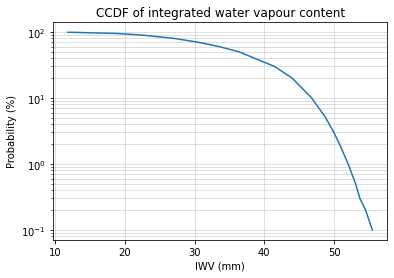

In [101]:
X, ccdf = plotcdf(tcwv_d, 0)
Xn = interp_list(ccdf, X, prob_nom)
plt.semilogy(Xn, prob_nom)
plt.grid(True, which="both", alpha=0.5)
plt.title('CCDF of integrated water vapour content')
plt.xlabel('IWV (mm)')
plt.ylabel('Probability (%)')
plt.show()

In [102]:
at_20, at_40, at_50, at_75 = calc_at(tcwv_d, [20, 40, 50, 75], -17.9074, -63.3266)
X_20, ccdf_20 = plotcdf(at_20, 0)
X_40, ccdf_40 = plotcdf(at_40, 0)
X_50, ccdf_50 = plotcdf(at_50, 0)
X_75, ccdf_75 = plotcdf(at_75, 0)
X_20n = interp_list(ccdf_20, X_20, prob_nom)
X_40n = interp_list(ccdf_40, X_40, prob_nom)
X_50n = interp_list(ccdf_50, X_50, prob_nom)
X_75n = interp_list(ccdf_75, X_75, prob_nom)

<Figure size 432x288 with 0 Axes>

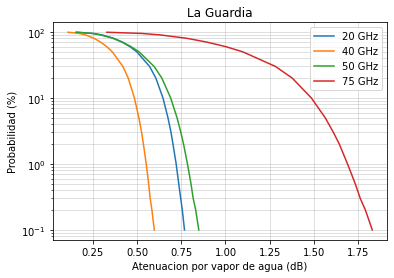

In [103]:
plt.grid(True, which="both", alpha=0.5)
plt.semilogy(X_20n, prob_nom, label='20 GHz')
plt.semilogy(X_40n, prob_nom, label='40 GHz')
plt.semilogy(X_50n, prob_nom, label='50 GHz')
plt.semilogy(X_75n, prob_nom, label='75 GHz')
plt.legend(loc='best')
plt.title('La Guardia')
plt.xlabel('Atenuacion por vapor de agua (dB)')
plt.ylabel('Probabilidad (%)')
plt.show()

In [104]:
dfindex = ['Probabilities', 'IWV', 'A20', 'A40', 'A50', 'A75']
results = pd.DataFrame(np.column_stack([prob_nom, Xn, X_20n, X_40n, X_50n, X_75n]), columns=dfindex)
display(results)
results.to_csv('TCWV/LaGuardia/CCDF_ERA5.csv', index=False)

,Probabilities,IWV,A20,A40,A50,A75
0,0.1,55.475582,0.768157,0.597100,0.848999,1.830533
1,0.2,54.521130,0.755645,0.583786,0.831533,1.791641
2,0.3,53.703516,0.746656,0.573824,0.817325,1.762613
3,0.5,53.083898,0.735540,0.565251,0.804811,1.734255
4,1.0,52.018807,0.720911,0.551596,0.784844,1.690543
5,2.0,50.776994,0.702885,0.535548,0.762659,1.643936
6,3.0,49.968132,0.691908,0.525531,0.747588,1.610672
7,5.0,48.802812,0.674565,0.510009,0.726114,1.564475
8,10.0,46.788355,0.646264,0.484745,0.689778,1.485805
9,20.0,43.985522,0.605863,0.449783,0.639740,1.377535


### San Ignacio de Moxos

In [67]:
tcwv_d = []
loadlist(tcwv_d, 'TCWV/SIMoxos/itcwv_12.txt')

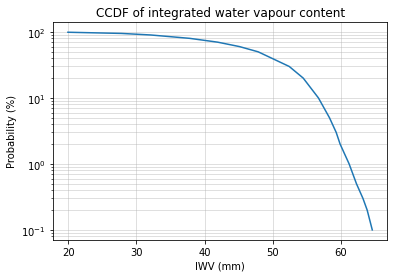

In [68]:
X, ccdf = plotcdf(tcwv_d, 0)
Xn = interp_list(ccdf, X, prob_nom)
plt.semilogy(Xn, prob_nom)
plt.grid(True, which="both", alpha=0.5)
plt.title('CCDF of integrated water vapour content')
plt.xlabel('IWV (mm)')
plt.ylabel('Probability (%)')
plt.show()

In [69]:
at_20, at_40, at_50, at_75 = calc_at(tcwv_d, [20, 40, 50, 75], -14.996641, -65.640895)
X_20, ccdf_20 = plotcdf(at_20, 0)
X_40, ccdf_40 = plotcdf(at_40, 0)
X_50, ccdf_50 = plotcdf(at_50, 0)
X_75, ccdf_75 = plotcdf(at_75, 0)
X_20n = interp_list(ccdf_20, X_20, prob_nom)
X_40n = interp_list(ccdf_40, X_40, prob_nom)
X_50n = interp_list(ccdf_50, X_50, prob_nom)
X_75n = interp_list(ccdf_75, X_75, prob_nom)

<Figure size 432x288 with 0 Axes>

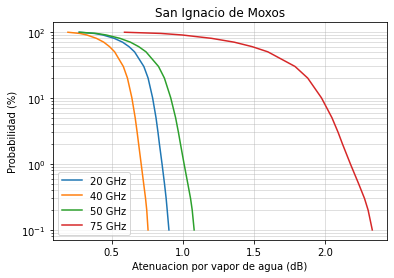

In [73]:
plt.grid(True, which="both", alpha=0.5)
plt.semilogy(X_20n, prob_nom, label='20 GHz')
plt.semilogy(X_40n, prob_nom, label='40 GHz')
plt.semilogy(X_50n, prob_nom, label='50 GHz')
plt.semilogy(X_75n, prob_nom, label='75 GHz')
plt.legend(loc='best')
plt.title('San Ignacio de Moxos')
plt.xlabel('Atenuacion por vapor de agua (dB)')
plt.ylabel('Probabilidad (%)')
plt.show()

In [72]:
dfindex = ['Probabilities', 'IWV', 'A20', 'A40', 'A50', 'A75']
results = pd.DataFrame(np.column_stack([prob_nom, Xn, X_20n, X_40n, X_50n, X_75n]), columns=dfindex)
display(results)
results.to_csv('TCWV/SIMoxos/CCDF_ERA5.csv', index=False)

,Probabilities,IWV,A20,A40,A50,A75
0,0.1,64.631278,0.903007,0.756297,1.080111,2.331200
1,0.2,63.880956,0.890850,0.747179,1.066535,2.301889
2,0.3,63.263337,0.883521,0.738773,1.054823,2.276602
3,0.5,62.312025,0.871876,0.725722,1.035786,2.235503
4,1.0,61.233977,0.854646,0.708085,1.009438,2.177477
5,2.0,59.906837,0.836287,0.690265,0.984192,2.122138
6,3.0,59.336684,0.826293,0.679932,0.969879,2.091453
7,5.0,58.351832,0.812365,0.666039,0.950024,2.048205
8,10.0,56.726335,0.788489,0.642919,0.915900,1.974714
9,20.0,54.489409,0.756697,0.611595,0.871138,1.877762


### UPB

In [74]:
tcwv_d = []
loadlist(tcwv_d, 'TCWV/UPB/itcwv_12.txt')

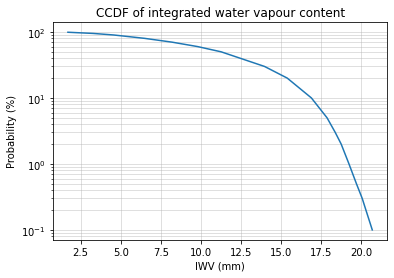

In [75]:
X, ccdf = plotcdf(tcwv_d, 0)
Xn = interp_list(ccdf, X, prob_nom)
plt.semilogy(Xn, prob_nom)
plt.grid(True, which="both", alpha=0.5)
plt.title('CCDF of integrated water vapour content')
plt.xlabel('IWV (mm)')
plt.ylabel('Probability (%)')
plt.show()

In [76]:
at_20, at_40, at_50, at_75 = calc_at(tcwv_d, [20, 40, 50, 75], -17.399253, -66.218466)
X_20, ccdf_20 = plotcdf(at_20, 0)
X_40, ccdf_40 = plotcdf(at_40, 0)
X_50, ccdf_50 = plotcdf(at_50, 0)
X_75, ccdf_75 = plotcdf(at_75, 0)
X_20n = interp_list(ccdf_20, X_20, prob_nom)
X_40n = interp_list(ccdf_40, X_40, prob_nom)
X_50n = interp_list(ccdf_50, X_50, prob_nom)
X_75n = interp_list(ccdf_75, X_75, prob_nom)

<Figure size 432x288 with 0 Axes>

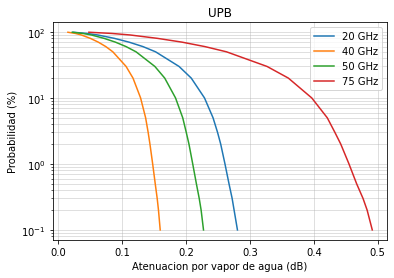

In [78]:
plt.grid(True, which="both", alpha=0.5)
plt.semilogy(X_20n, prob_nom, label='20 GHz')
plt.semilogy(X_40n, prob_nom, label='40 GHz')
plt.semilogy(X_50n, prob_nom, label='50 GHz')
plt.semilogy(X_75n, prob_nom, label='75 GHz')
plt.legend(loc='best')
plt.title('UPB')
plt.xlabel('Atenuacion por vapor de agua (dB)')
plt.ylabel('Probabilidad (%)')
plt.show()

In [79]:
dfindex = ['Probabilities', 'IWV', 'A20', 'A40', 'A50', 'A75']
results = pd.DataFrame(np.column_stack([prob_nom, Xn, X_20n, X_40n, X_50n, X_75n]), columns=dfindex)
display(results)
results.to_csv('TCWV/UPB/CCDF_ERA5.csv', index=False)

,Probabilities,IWV,A20,A40,A50,A75
0,0.1,20.687662,0.280556,0.159763,0.227476,0.491424
1,0.2,20.290904,0.275314,0.157052,0.223741,0.483359
2,0.3,20.060763,0.272260,0.155051,0.220778,0.476960
3,0.5,19.701155,0.267365,0.151997,0.216355,0.466975
4,1.0,19.234470,0.261052,0.147977,0.210621,0.454986
5,2.0,18.747442,0.254353,0.143712,0.204722,0.442105
6,3.0,18.378451,0.249482,0.140929,0.200536,0.433016
7,5.0,17.866859,0.242406,0.136956,0.194991,0.421055
8,10.0,16.890693,0.229029,0.129088,0.183735,0.396784
9,20.0,15.381899,0.208282,0.117187,0.166796,0.360137


### RAOBs Data

Data Loading

In [80]:
df = pd.read_csv('RAOB/RAOB.csv')
df.tail()

,IWV,Dates
941,1.5421,25-May-2020 12:12:26
942,1.8706,26-May-2020 12:14:27
943,2.1463,27-May-2020 12:52:09
944,3.5015,28-May-2020 12:08:11
945,4.0562,29-May-2020 12:21:23


In [105]:
iwv = df['IWV'].to_numpy()

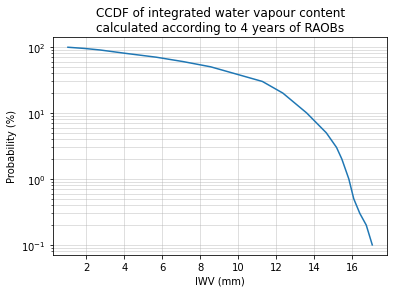

In [106]:
X, ccdf = plotcdf(iwv, 0, 100)
Xn = interp_list(ccdf, X, prob_nom)
plt.semilogy(Xn, prob_nom)
plt.grid(True, which="both", alpha=0.5)
plt.title('CCDF of integrated water vapour content\ncalculated according to 4 years of RAOBs')
plt.xlabel('IWV (mm)')
plt.ylabel('Probability (%)')
plt.show()

In [107]:
at_20, at_40, at_50, at_75 = calc_at(iwv, [20, 40, 50, 75], -16.51, -68.17)
X_20, ccdf_20 = plotcdf(at_20, 0, 100)
X_40, ccdf_40 = plotcdf(at_40, 0, 100)
X_50, ccdf_50 = plotcdf(at_50, 0, 100)
X_75, ccdf_75 = plotcdf(at_75, 0, 100)
X_20n = interp_list(ccdf_20, X_20, prob_nom)
X_40n = interp_list(ccdf_40, X_40, prob_nom)
X_50n = interp_list(ccdf_50, X_50, prob_nom)
X_75n = interp_list(ccdf_75, X_75, prob_nom)

<Figure size 432x288 with 0 Axes>

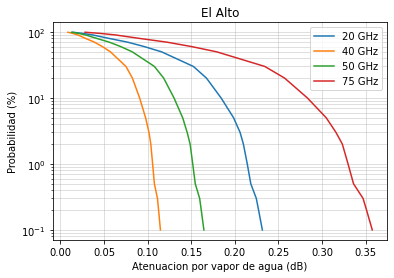

In [108]:
plt.grid(True, which="both", alpha=0.5)
plt.semilogy(X_20n, prob_nom, label='20 GHz')
plt.semilogy(X_40n, prob_nom, label='40 GHz')
plt.semilogy(X_50n, prob_nom, label='50 GHz')
plt.semilogy(X_75n, prob_nom, label='75 GHz')
plt.legend(loc='best')
plt.title('El Alto')
plt.xlabel('Atenuacion por vapor de agua (dB)')
plt.ylabel('Probabilidad (%)')
plt.show()

In [109]:
dfindex = ['Probabilities', 'IWV', 'A20', 'A40', 'A50', 'A75']
results = pd.DataFrame(np.column_stack([prob_nom, Xn, X_20n, X_40n, X_50n, X_75n]), columns=dfindex)
display(results)
results.to_csv('TCWV/ElAlto/CCDF_RAOB.csv', index=False)

,Probabilities,IWV,A20,A40,A50,A75
0,0.1,17.071199,0.231565,0.114726,0.164559,0.357585
1,0.2,16.752638,0.227248,0.112611,0.161529,0.351005
2,0.3,16.415359,0.224646,0.111336,0.159703,0.347039
3,0.5,16.094544,0.218332,0.107823,0.154669,0.336107
4,1.0,15.834565,0.214276,0.105796,0.151764,0.329800
5,2.0,15.467302,0.209833,0.103693,0.148751,0.323256
6,3.0,15.188084,0.206050,0.101614,0.145413,0.316007
7,5.0,14.647039,0.198624,0.097766,0.140259,0.304816
8,10.0,13.611586,0.184262,0.090876,0.130304,0.283196
9,20.0,12.355445,0.167482,0.082594,0.118425,0.257057


### ITU Data

### El Alto

In [23]:
df = pd.read_csv('TCWV/ElAlto/CCDF_ITU.csv')
iwv = df['IWV']
a20 = df['A20']
a40 = df['A40']
a50 = df['A50']
a75 = df['A75']

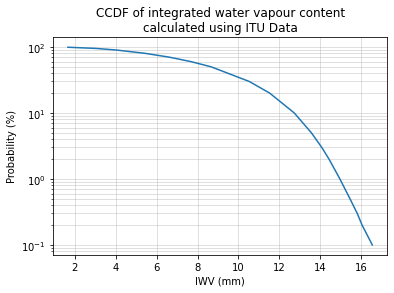

In [24]:
plt.semilogy(iwv, prob_nom)
plt.grid(True, which="both", alpha=0.5)
plt.title('CCDF of integrated water vapour content\ncalculated using ITU Data')
plt.xlabel('IWV (mm)')
plt.ylabel('Probability (%)')
plt.show()

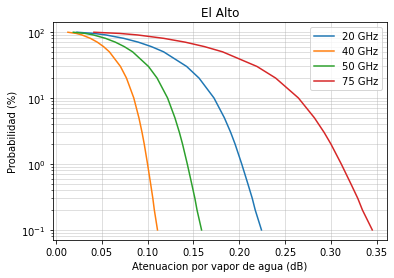

In [25]:
plt.grid(True, which="both", alpha=0.5)
plt.semilogy(a20, prob_nom, label='20 GHz')
plt.semilogy(a40, prob_nom, label='40 GHz')
plt.semilogy(a50, prob_nom, label='50 GHz')
plt.semilogy(a75, prob_nom, label='75 GHz')
plt.legend(loc='best')
plt.title('El Alto')
plt.xlabel('Atenuacion por vapor de agua (dB)')
plt.ylabel('Probabilidad (%)')
plt.show()

### La Guardia

In [26]:
df = pd.read_csv('TCWV/LaGuardia/CCDF_ITU.csv')
iwv = df['IWV']
a20 = df['A20']
a40 = df['A40']
a50 = df['A50']
a75 = df['A75']

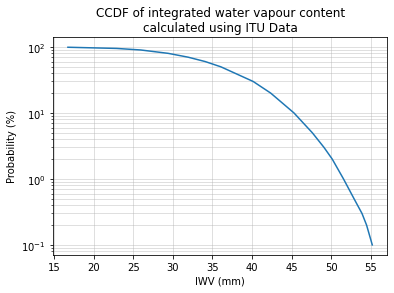

In [27]:
plt.semilogy(iwv, prob_nom)
plt.grid(True, which="both", alpha=0.5)
plt.title('CCDF of integrated water vapour content\ncalculated using ITU Data')
plt.xlabel('IWV (mm)')
plt.ylabel('Probability (%)')
plt.show()

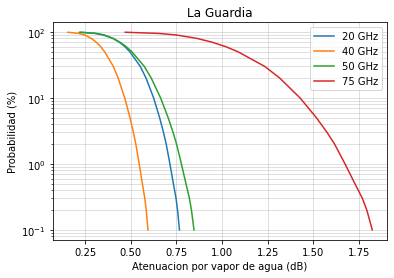

In [28]:
plt.grid(True, which="both", alpha=0.5)
plt.semilogy(a20, prob_nom, label='20 GHz')
plt.semilogy(a40, prob_nom, label='40 GHz')
plt.semilogy(a50, prob_nom, label='50 GHz')
plt.semilogy(a75, prob_nom, label='75 GHz')
plt.legend(loc='best')
plt.title('La Guardia')
plt.xlabel('Atenuacion por vapor de agua (dB)')
plt.ylabel('Probabilidad (%)')
plt.show()

### San Ignacio de Moxos

In [29]:
df = pd.read_csv('TCWV/SIMoxos/CCDF_ITU.csv')
iwv = df['IWV']
a20 = df['A20']
a40 = df['A40']
a50 = df['A50']
a75 = df['A75']

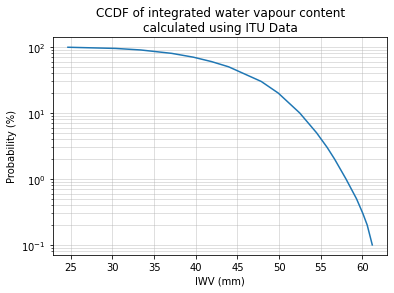

In [30]:
plt.semilogy(iwv, prob_nom)
plt.grid(True, which="both", alpha=0.5)
plt.title('CCDF of integrated water vapour content\ncalculated using ITU Data')
plt.xlabel('IWV (mm)')
plt.ylabel('Probability (%)')
plt.show()

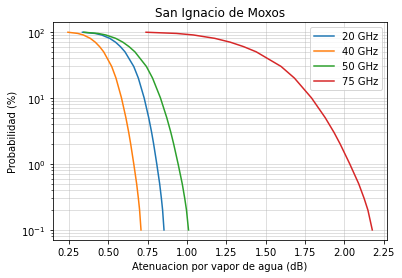

In [31]:
plt.grid(True, which="both", alpha=0.5)
plt.semilogy(a20, prob_nom, label='20 GHz')
plt.semilogy(a40, prob_nom, label='40 GHz')
plt.semilogy(a50, prob_nom, label='50 GHz')
plt.semilogy(a75, prob_nom, label='75 GHz')
plt.legend(loc='best')
plt.title('San Ignacio de Moxos')
plt.xlabel('Atenuacion por vapor de agua (dB)')
plt.ylabel('Probabilidad (%)')
plt.show()

### UPB

In [32]:
df = pd.read_csv('TCWV/UPB/CCDF_ITU.csv')
iwv = df['IWV']
a20 = df['A20']
a40 = df['A40']
a50 = df['A50']
a75 = df['A75']

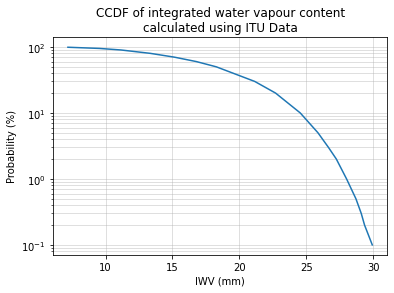

In [33]:
plt.semilogy(iwv, prob_nom)
plt.grid(True, which="both", alpha=0.5)
plt.title('CCDF of integrated water vapour content\ncalculated using ITU Data')
plt.xlabel('IWV (mm)')
plt.ylabel('Probability (%)')
plt.show()

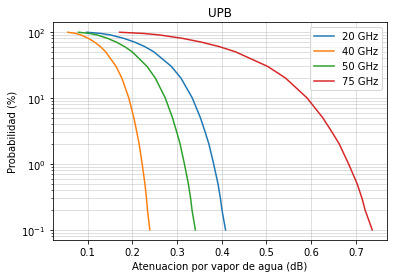

In [34]:
plt.grid(True, which="both", alpha=0.5)
plt.semilogy(a20, prob_nom, label='20 GHz')
plt.semilogy(a40, prob_nom, label='40 GHz')
plt.semilogy(a50, prob_nom, label='50 GHz')
plt.semilogy(a75, prob_nom, label='75 GHz')
plt.legend(loc='best')
plt.title('UPB')
plt.xlabel('Atenuacion por vapor de agua (dB)')
plt.ylabel('Probabilidad (%)')
plt.show()